# Event space CWoLa

This notebook runs a weakly supervised CWoLa training procedure on the event space representations.

The CWoLa procedure can be run either with an FCN or a LCT.


In [30]:
# imports
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_curve


# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules
from modules.jet_augs import remove_jet_and_rescale_pT
from modules.neural_net import create_and_run_nn
from modules.CWoLa_helpers import generate_mixed_sample, generate_train_test_val
from modules.post_processing import calc_auc_and_macSIC, calc_FPR_at_TPR


seed = 5
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.empty_cache()

from numba import cuda 
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = cuda.get_current_device()
device.reset()

torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
device = torch.device( "cpu")
print( "device: " + str( device ), flush=True)


device: cpu


## Load in the data + crop

In [31]:
path_to_save_dir = "/global/home/users/rrmastandrea/MJetCLR/training_data_vf/"

sig_samp_id = "nCWoLa_sig_85000_nCWoLa_bkg_0_n_nonzero_50_n_pad_0_n_jet_2/"
bkg_samp_id = "nCWoLa_sig_0_nCWoLa_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/"

TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

n_constits_max = 50
n_jets = 2

path_to_sig_data = path_to_save_dir+sig_samp_id
print(path_to_sig_data)
path_to_bkg_data = path_to_save_dir+bkg_samp_id
print(path_to_bkg_data)

path_to_STS = path_to_save_dir+TEST_dir
print(path_to_STS)


sig_data = np.load(path_to_sig_data+"data_train.npy")
sig_labels = np.load(path_to_sig_data+"labels_train.npy")
bkg_data = np.load(path_to_bkg_data+"data_train.npy")
bkg_labels = np.load(path_to_bkg_data+"labels_train.npy")
STS_data = np.load(path_to_STS+"data.npy")
STS_labels = np.load(path_to_STS+"labels.npy")


# Crop the data, rescale pt
cropped_sig_data = remove_jet_and_rescale_pT(sig_data, n_jets)
cropped_bkg_data = remove_jet_and_rescale_pT(bkg_data, n_jets)
cropped_STS_data = remove_jet_and_rescale_pT(STS_data, n_jets)

# print data dimensions
print( "Sig data shape: " + str( cropped_sig_data.shape ), flush=True)
print( "Sig labels shape: " + str( sig_labels.shape ), flush=True)
print( "Bkg data shape: " + str( cropped_bkg_data.shape ), flush=True)
print( "Sig data shape: " + str( bkg_labels.shape ), flush=True)


print( "STS data shape: " + str( cropped_STS_data.shape ), flush=True)
print( "STS labels shape: " + str( STS_labels.shape ), flush=True)

num_consts_tot = 100

cropped_STS_data = np.reshape(cropped_STS_data,(cropped_STS_data.shape[0],3*num_consts_tot))


/global/home/users/rrmastandrea/MJetCLR/training_data_vf/nCWoLa_sig_85000_nCWoLa_bkg_0_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/MJetCLR/training_data_vf/nCWoLa_sig_0_nCWoLa_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/MJetCLR/training_data_vf/STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/
Sig data shape: (85000, 3, 100)
Sig labels shape: (85000,)
Bkg data shape: (85000, 3, 100)
Sig data shape: (85000,)
STS data shape: (20000, 3, 100)
STS labels shape: (20000,)


In [32]:
# For the actual anomaly detection, we need to split the datasets in half
# i.e. the first "mixed" sample is the first half of the background events
# the second mixed sample is a blend of the second half of the background events

cropped_sig_data = remove_jet_and_rescale_pT(sig_data, n_jets)
cropped_bkg_data = remove_jet_and_rescale_pT(bkg_data, n_jets)

first_half_sig_data = cropped_sig_data[:42500]
second_half_sig_data = cropped_sig_data[42500:]

first_half_bkg_data = cropped_bkg_data[:42500]
second_half_bkg_data = cropped_bkg_data[42500:]

## Test the classifier in the fully supervised cse

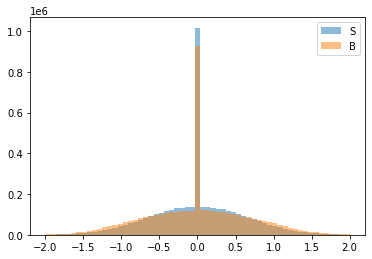

In [33]:
# Make the datasets


layer = 1 # here, 0 = p_t, 1 = eta, 2 = phi
  
M1 = first_half_sig_data
M2 = first_half_bkg_data
bins = np.linspace(-2,2,60)
    
S = np.reshape(M1[:,layer,:], (M1.shape[0]*M1.shape[2],1))
B = np.reshape(M2[:,layer,:], (M2.shape[0]*M2.shape[2],1))


plt.figure()
plt.hist(S, bins, label = "S", alpha = 0.5)
plt.hist(B, bins, label = "B", alpha = 0.5)
plt.legend()
plt.show()

Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide


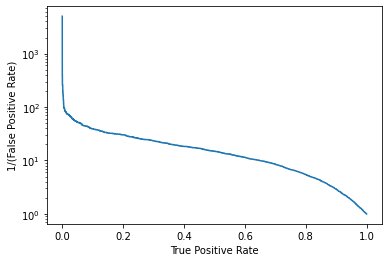

ROC AUC: 0.86404287


/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


In [34]:
data_train, labels_train, data_val, labels_val = generate_train_test_val(M1, M2)

# Define the NN parameters

full_sup_AUC = 0
full_sup_maxsic = 0
fixed_TPR = 0.5
full_sup_FPRatTPR = 0

data_train = np.reshape(data_train,(data_train.shape[0],3*num_consts_tot))
data_val = np.reshape(data_val,(data_val.shape[0],3*num_consts_tot))

# print data dimensions
print( "Train data shape: " + str( data_train.shape ), flush=True)
print( "Train labels shape: " + str( labels_train.shape ), flush=True)
print( "Val data shape: " + str( data_val.shape ), flush=True)
print( "Val labels shape: " + str( labels_val.shape ), flush=True)

# parameters for a dense NN
input_shape = 3*num_consts_tot   
num_epochs = 1000
batch_size = 500
update_epochs = 10
lr = 0.0001

run_LCT = True

if not run_LCT:
    # Run the NN
    performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                                  data_train, labels_train, 
                                  data_val, labels_val,
                                  cropped_STS_data, STS_labels, 
                                  verbose = True, early_stop = True, LRschedule = False)
    
    # Plot the output losses   
    plt.figure()
    plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
    plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.yscale("log")
    plt.legend()
    plt.show()
    
    loc_fpr = performance_stats["fpr"]
    loc_tpr = performance_stats["tpr"]
    
    

else: 
    # Run a LCT
    ridge = Ridge(alpha=1.0)
    ridge.fit(data_train, labels_train)

    # make the prediction
    predictions = ridge.predict(cropped_STS_data)
    loc_fpr, loc_tpr, _ = roc_curve(STS_labels, predictions)
    

plt.figure()
plt.plot(loc_tpr, 1.0/loc_fpr)
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.show()


full_sup_AUC, full_sup_maxsic = calc_auc_and_macSIC(loc_fpr, loc_tpr)
full_sup_FPRatTPR = calc_FPR_at_TPR(loc_fpr, loc_tpr)


print("ROC AUC:", full_sup_AUC)


## Test the classifier in the weakly supervised case# Testing the classifier (CWoLa)

Starting LCT CWoLa training run with f1 = 0
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


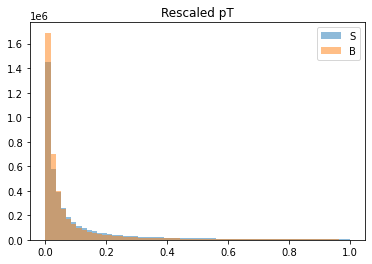

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


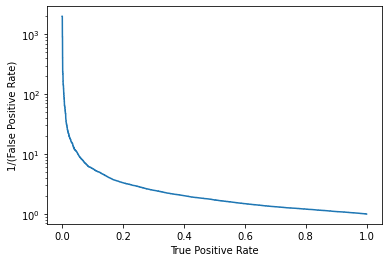

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.56411158

Starting LCT CWoLa training run with f1 = 0.0001
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


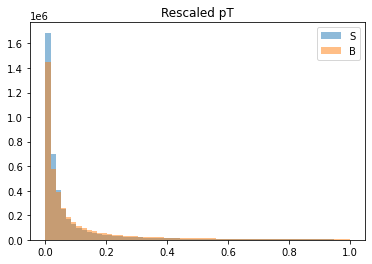

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


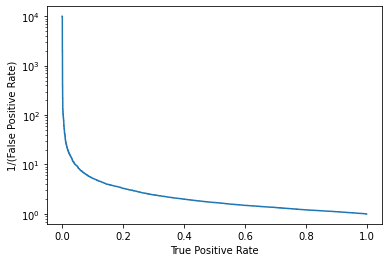

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: divide by zero encountered in true_divide
  SIC = tpr/np.sqrt(fpr)
/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.56471379

Starting LCT CWoLa training run with f1 = 0.0005
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


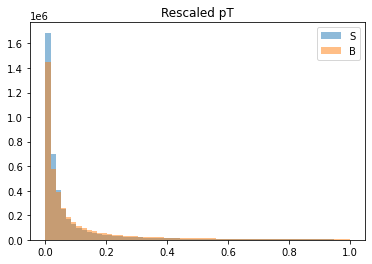

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


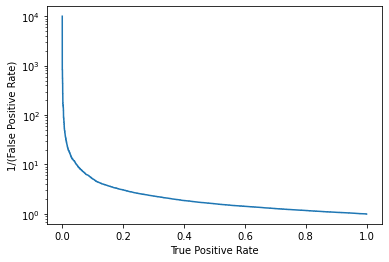

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.5891047

Starting LCT CWoLa training run with f1 = 0.001
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


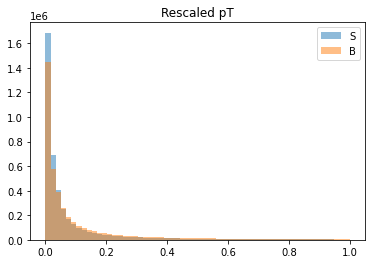

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


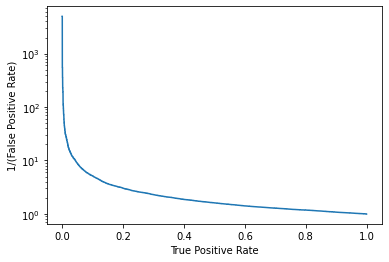

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.5895481300000001

Starting LCT CWoLa training run with f1 = 0.005
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


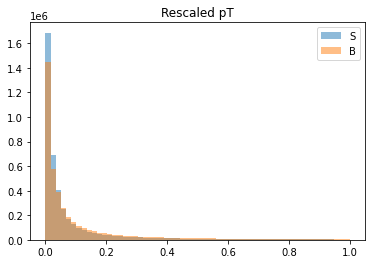

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


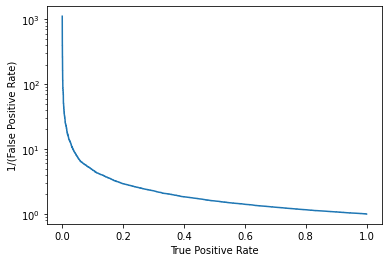

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.59831692

Starting LCT CWoLa training run with f1 = 0.01
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


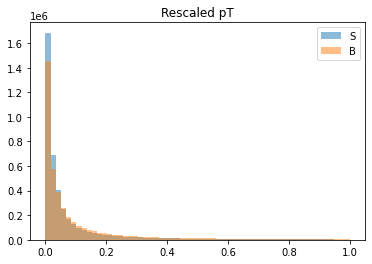

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


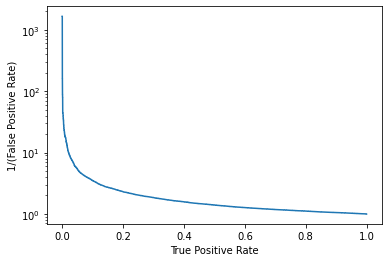

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.66460491

Starting LCT CWoLa training run with f1 = 0.05
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


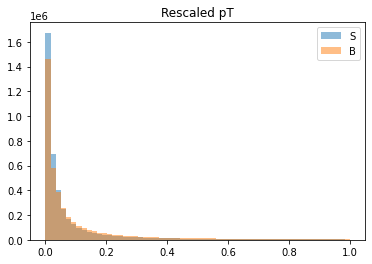

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


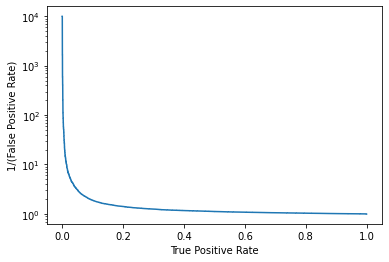

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.81702073

Starting LCT CWoLa training run with f1 = 0.1
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


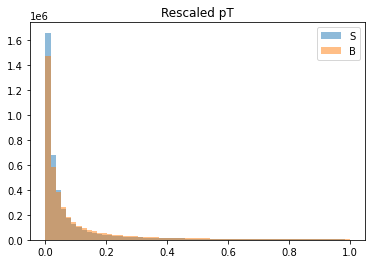

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


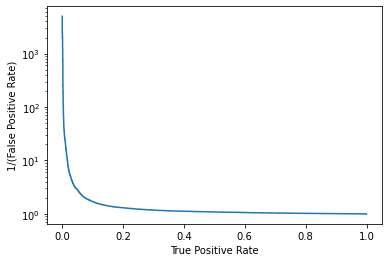

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.84440076

Starting LCT CWoLa training run with f1 = 0.2
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


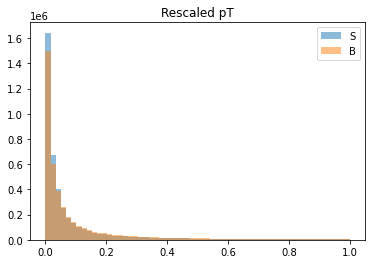

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


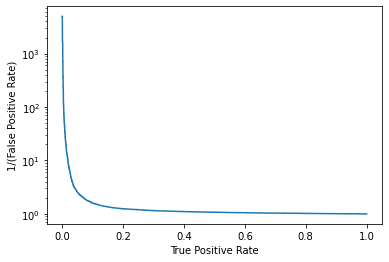

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.85654904

Starting LCT CWoLa training run with f1 = 0.3
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


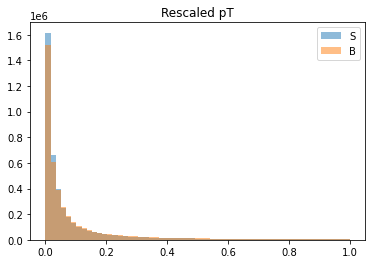

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


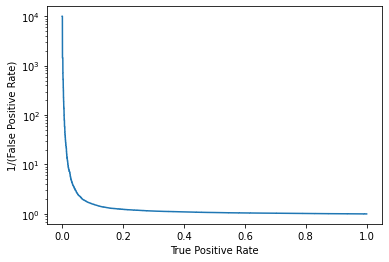

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.8612339600000001

Starting LCT CWoLa training run with f1 = 0.4
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


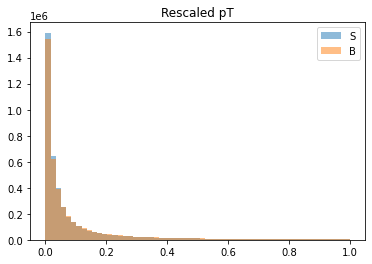

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


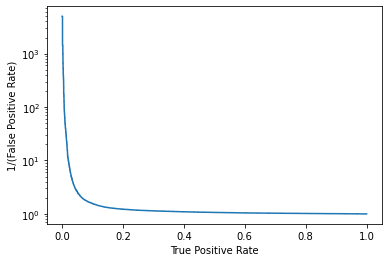

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.86356684

Starting LCT CWoLa training run with f1 = 0.6
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


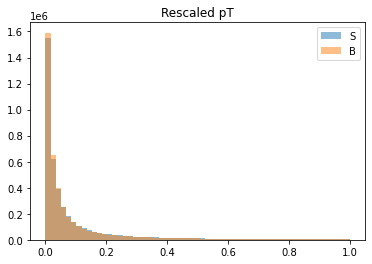

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


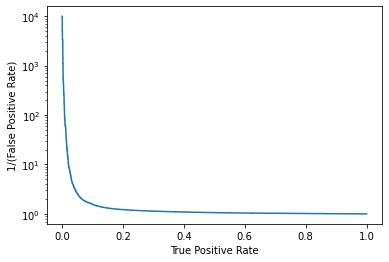

/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


ROC AUC: 0.86471945

Starting LCT CWoLa training run with f1 = 1
Train data shape: (59500, 300)
Train labels shape: (59500,)
Val data shape: (25500, 300)
Val labels shape: (25500,)


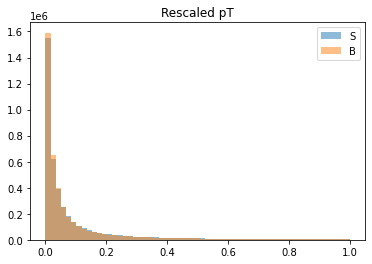

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in true_divide


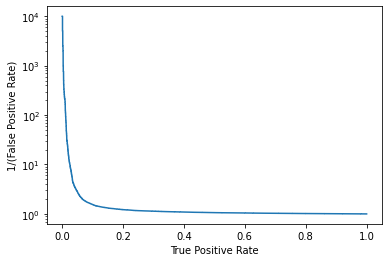

ROC AUC: 0.8636848399999999



/global/home/users/rrmastandrea/JetCLR_AD/scripts/modules/post_processing.py:9: RuntimeWarning: invalid value encountered in true_divide
  SIC = tpr/np.sqrt(fpr)


In [35]:
# Define the NN parameters

input_shape = 3*num_consts_tot
num_epochs = 1000
batch_size = 500
update_epochs = 10
lr = 0.0001

visualize = True
run_LCT = True

f1_vals = []
ROC_AUC_vals = []
maxsic_vals = []
FPRatTPR_vals = []

f1_to_probe = [0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 1]

for f1 in f1_to_probe:
    
    if run_LCT:
        print("Starting LCT CWoLa training run with f1 =", f1)
    else:
        print("Starting FCN CWoLa training run with f1 =", f1)
    f1_vals.append(f1)
    
    
    if f1 == 0: # weird bug unless this is manually dne
        data_train, labels_train, data_val, labels_val = generate_train_test_val(second_half_bkg_data, first_half_bkg_data)
    elif f1 == 1:
        data_train, labels_train, data_val, labels_val = generate_train_test_val(second_half_sig_data, first_half_bkg_data)
    else:
        # make the datasets / mixed samples
        # We only want to keep M1 here, as that's the set with a fraction f of the anomaly 
        M1, M2 = generate_mixed_sample(second_half_sig_data, second_half_bkg_data, f1)
    
        # The other "mixed" sample is background only
        data_train, labels_train, data_val, labels_val = generate_train_test_val(M1, first_half_bkg_data)
        
    data_train = np.reshape(data_train,(data_train.shape[0],3*num_consts_tot))
    data_val = np.reshape(data_val,(data_val.shape[0],3*num_consts_tot))

    # print data dimensions
    print( "Train data shape: " + str( data_train.shape ), flush=True)
    print( "Train labels shape: " + str( labels_train.shape ), flush=True)
    print( "Val data shape: " + str( data_val.shape ), flush=True)
    print( "Val labels shape: " + str( labels_val.shape ), flush=True)

    # Run the NN

    # visualise the mixed samples

    if visualize:

        S = np.reshape(M1[:,0,:], (M1.shape[0]*M1.shape[2],1))
        B = np.reshape(M2[:,0,:], (M2.shape[0]*M2.shape[2],1))

        bins = np.linspace(0,1,60)
        plt.figure()
        plt.hist(S, bins, label = "S", alpha = 0.5)
        plt.hist(B, bins, label = "B", alpha = 0.5)
        plt.legend()
        plt.title("Rescaled pT")
        plt.show()
        
    if not run_LCT:

        performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                              data_train, labels_train, 
                              data_val, labels_val,
                              cropped_STS_data, STS_labels, 
                              verbose = True, early_stop = True, LRschedule = False)

        loc_fpr = performance_stats["fpr"]
        loc_tpr = performance_stats["tpr"]

        if visualize:
            # Plot the output losses   
            plt.figure()
            plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
            plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
            plt.xlabel("Epochs")
            plt.ylabel("Losses")
            plt.yscale("log")
            plt.legend()
            plt.show()
            
    else:
        ridge = Ridge(alpha=1.0)
        ridge.fit(data_train, labels_train)
        # make the prediction
        predictions = ridge.predict(cropped_STS_data)
        loc_fpr, loc_tpr, _ = roc_curve(STS_labels, predictions)
        
    plt.figure()
    plt.plot(loc_fpr, 1.0/loc_tpr)
    plt.yscale("log")
    plt.xlabel("True Positive Rate")
    plt.ylabel("1/(False Positive Rate)")
    plt.show()
        

    full_sup_AUC, full_sup_maxsic = calc_auc_and_macSIC(loc_fpr, loc_tpr)
    full_sup_FPRatTPR = calc_FPR_at_TPR(loc_fpr, loc_tpr)

    
    print("ROC AUC:", full_sup_AUC)

    ROC_AUC_vals.append(full_sup_AUC)
    maxsic_vals.append(full_sup_maxsic)
    FPRatTPR_vals.append(full_sup_FPRatTPR)
  
    print()




In [36]:
run_LCT = True

if not run_LCT:
    cwola_npy_save_dict = "/global/home/users/rrmastandrea/MJetCLR/CWoLa_results_npy/const_rep/"
else: 
    cwola_npy_save_dict = "/global/home/users/rrmastandrea/MJetCLR/CWoLa_results_npy/const_rep_linear/"

# save the f1 vals scanned over
np.save(cwola_npy_save_dict+"f1_vals_seed"+str(seed), f1_vals)

    
# save the full sup 
np.save(cwola_npy_save_dict+"full_sup_AUC"+"_seed"+str(seed), np.full(len(f1_vals), full_sup_AUC))
np.save(cwola_npy_save_dict+"full_sup_maxsic"+"_seed"+str(seed), np.full(len(f1_vals), full_sup_maxsic))
np.save(cwola_npy_save_dict+"full_sup_FPRatTPR"+"_seed"+str(seed), np.full(len(f1_vals), full_sup_FPRatTPR))

# save the Cwola
np.save(cwola_npy_save_dict+"CWoLa_AUC_layer"+"_seed"+str(seed), [max(x, 1.0-x) for x in ROC_AUC_vals])
np.save(cwola_npy_save_dict+"CWoLa_sup_maxsic"+"_seed"+str(seed), maxsic_vals)
np.save(cwola_npy_save_dict+"CWoLa_sup_FPRatTPR"+"_seed"+str(seed), FPRatTPR_vals)



In [37]:
run_LCT = False

if not run_LCT:
    cwola_npy_save_dict = "/global/home/users/rrmastandrea/MJetCLR/CWoLa_results_npy/const_rep/"
else: 
    cwola_npy_save_dict = "/global/home/users/rrmastandrea/MJetCLR/CWoLa_results_npy/const_rep_linear/"
    

seeds = [1, 2, 3, 4, 5]


full_sup_results_dict = {seed:{"AUC":0
                               ,
                        "maxsic":0,
                        "FPRatTPR":0,} for seed in seeds}

cwola_results_dict = {seed:{"AUC":0,
                        "maxsic":0,
                        "FPRatTPR":0,} for seed in seeds}

for seed in seeds:

    full_sup_results_dict[seed]["AUC"] = np.load(cwola_npy_save_dict+"full_sup_AUC"+"_seed"+str(seed)+".npy")
    full_sup_results_dict[seed]["maxsic"] = np.load(cwola_npy_save_dict+"full_sup_maxsic"+"_seed"+str(seed)+".npy")
    full_sup_results_dict[seed]["FPRatTPR"] = np.load(cwola_npy_save_dict+"full_sup_FPRatTPR"+"_seed"+str(seed)+".npy")

    cwola_results_dict[seed]["AUC"] = np.load(cwola_npy_save_dict+"CWoLa_AUC_layer"+"_seed"+str(seed)+".npy")
    cwola_results_dict[seed]["maxsic"] = np.load(cwola_npy_save_dict+"CWoLa_sup_maxsic"+"_seed"+str(seed)+".npy")
    cwola_results_dict[seed]["FPRatTPR"] = np.load(cwola_npy_save_dict+"CWoLa_sup_FPRatTPR"+"_seed"+str(seed)+".npy")
    
f1_vals = np.load(cwola_npy_save_dict+"f1_vals_seed"+str(1)+".npy")



# for each f1 val, calculate the mean and std from the seeds
avg_full_sup_results_dict = {"AUC":[[],[]],  # vals, errors
                        "maxsic":[[],[]],
                        "FPRatTPR":[[],[]],}
avg_cwola_results_dict = {"AUC":[[],[]],
                        "maxsic":[[],[]],
                        "FPRatTPR":[[],[]],}


for i in range(len(f1_vals)):
    avg_full_sup_results_dict["AUC"][0].append(np.mean([full_sup_results_dict[seed]["AUC"][i] for seed in seeds]))
    avg_full_sup_results_dict["AUC"][1].append(np.std([full_sup_results_dict[seed]["AUC"][i] for seed in seeds]))
    avg_full_sup_results_dict["maxsic"][0].append(np.mean([full_sup_results_dict[seed]["maxsic"][i] for seed in seeds]))
    avg_full_sup_results_dict["maxsic"][1].append(np.std([full_sup_results_dict[seed]["maxsic"][i] for seed in seeds]))
    avg_full_sup_results_dict["FPRatTPR"][0].append(np.mean([full_sup_results_dict[seed]["FPRatTPR"][i] for seed in seeds]))
    avg_full_sup_results_dict["FPRatTPR"][1].append(np.std([full_sup_results_dict[seed]["FPRatTPR"][i] for seed in seeds]))
    
    avg_cwola_results_dict["AUC"][0].append(np.mean([cwola_results_dict[seed]["AUC"][i] for seed in seeds]))
    avg_cwola_results_dict["AUC"][1].append(np.std([cwola_results_dict[seed]["AUC"][i] for seed in seeds]))
    avg_cwola_results_dict["maxsic"][0].append(np.mean([cwola_results_dict[seed]["maxsic"][i] for seed in seeds]))
    avg_cwola_results_dict["maxsic"][1].append(np.std([cwola_results_dict[seed]["maxsic"][i] for seed in seeds]))
    avg_cwola_results_dict["FPRatTPR"][0].append(np.mean([cwola_results_dict[seed]["FPRatTPR"][i] for seed in seeds]))
    avg_cwola_results_dict["FPRatTPR"][1].append(np.std([cwola_results_dict[seed]["FPRatTPR"][i] for seed in seeds]))
    




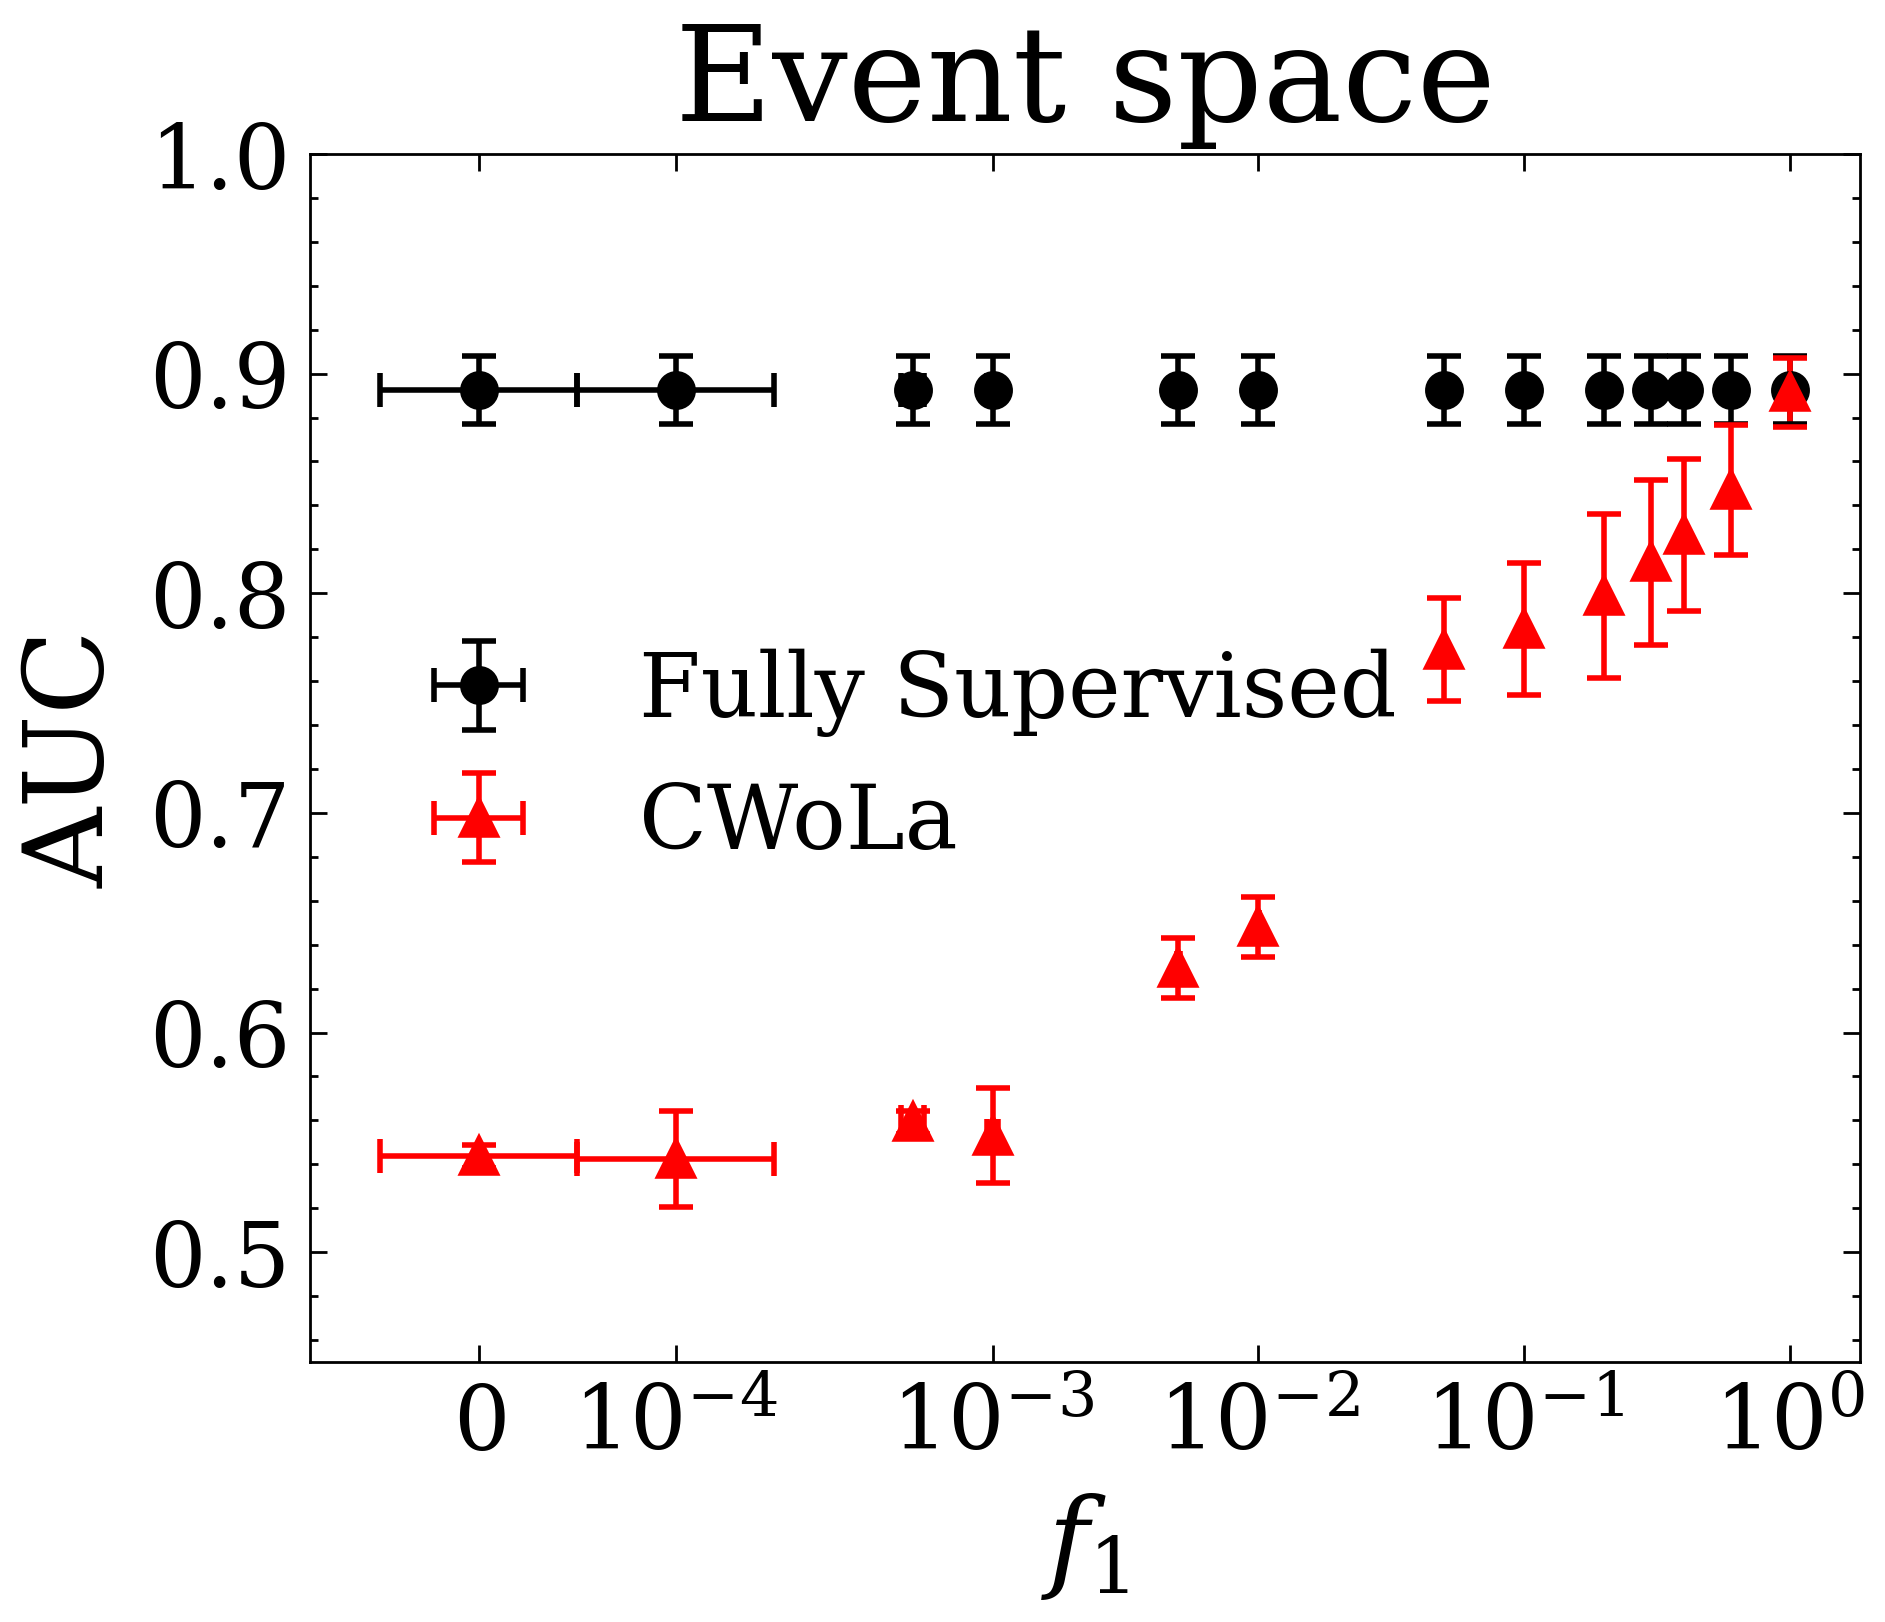

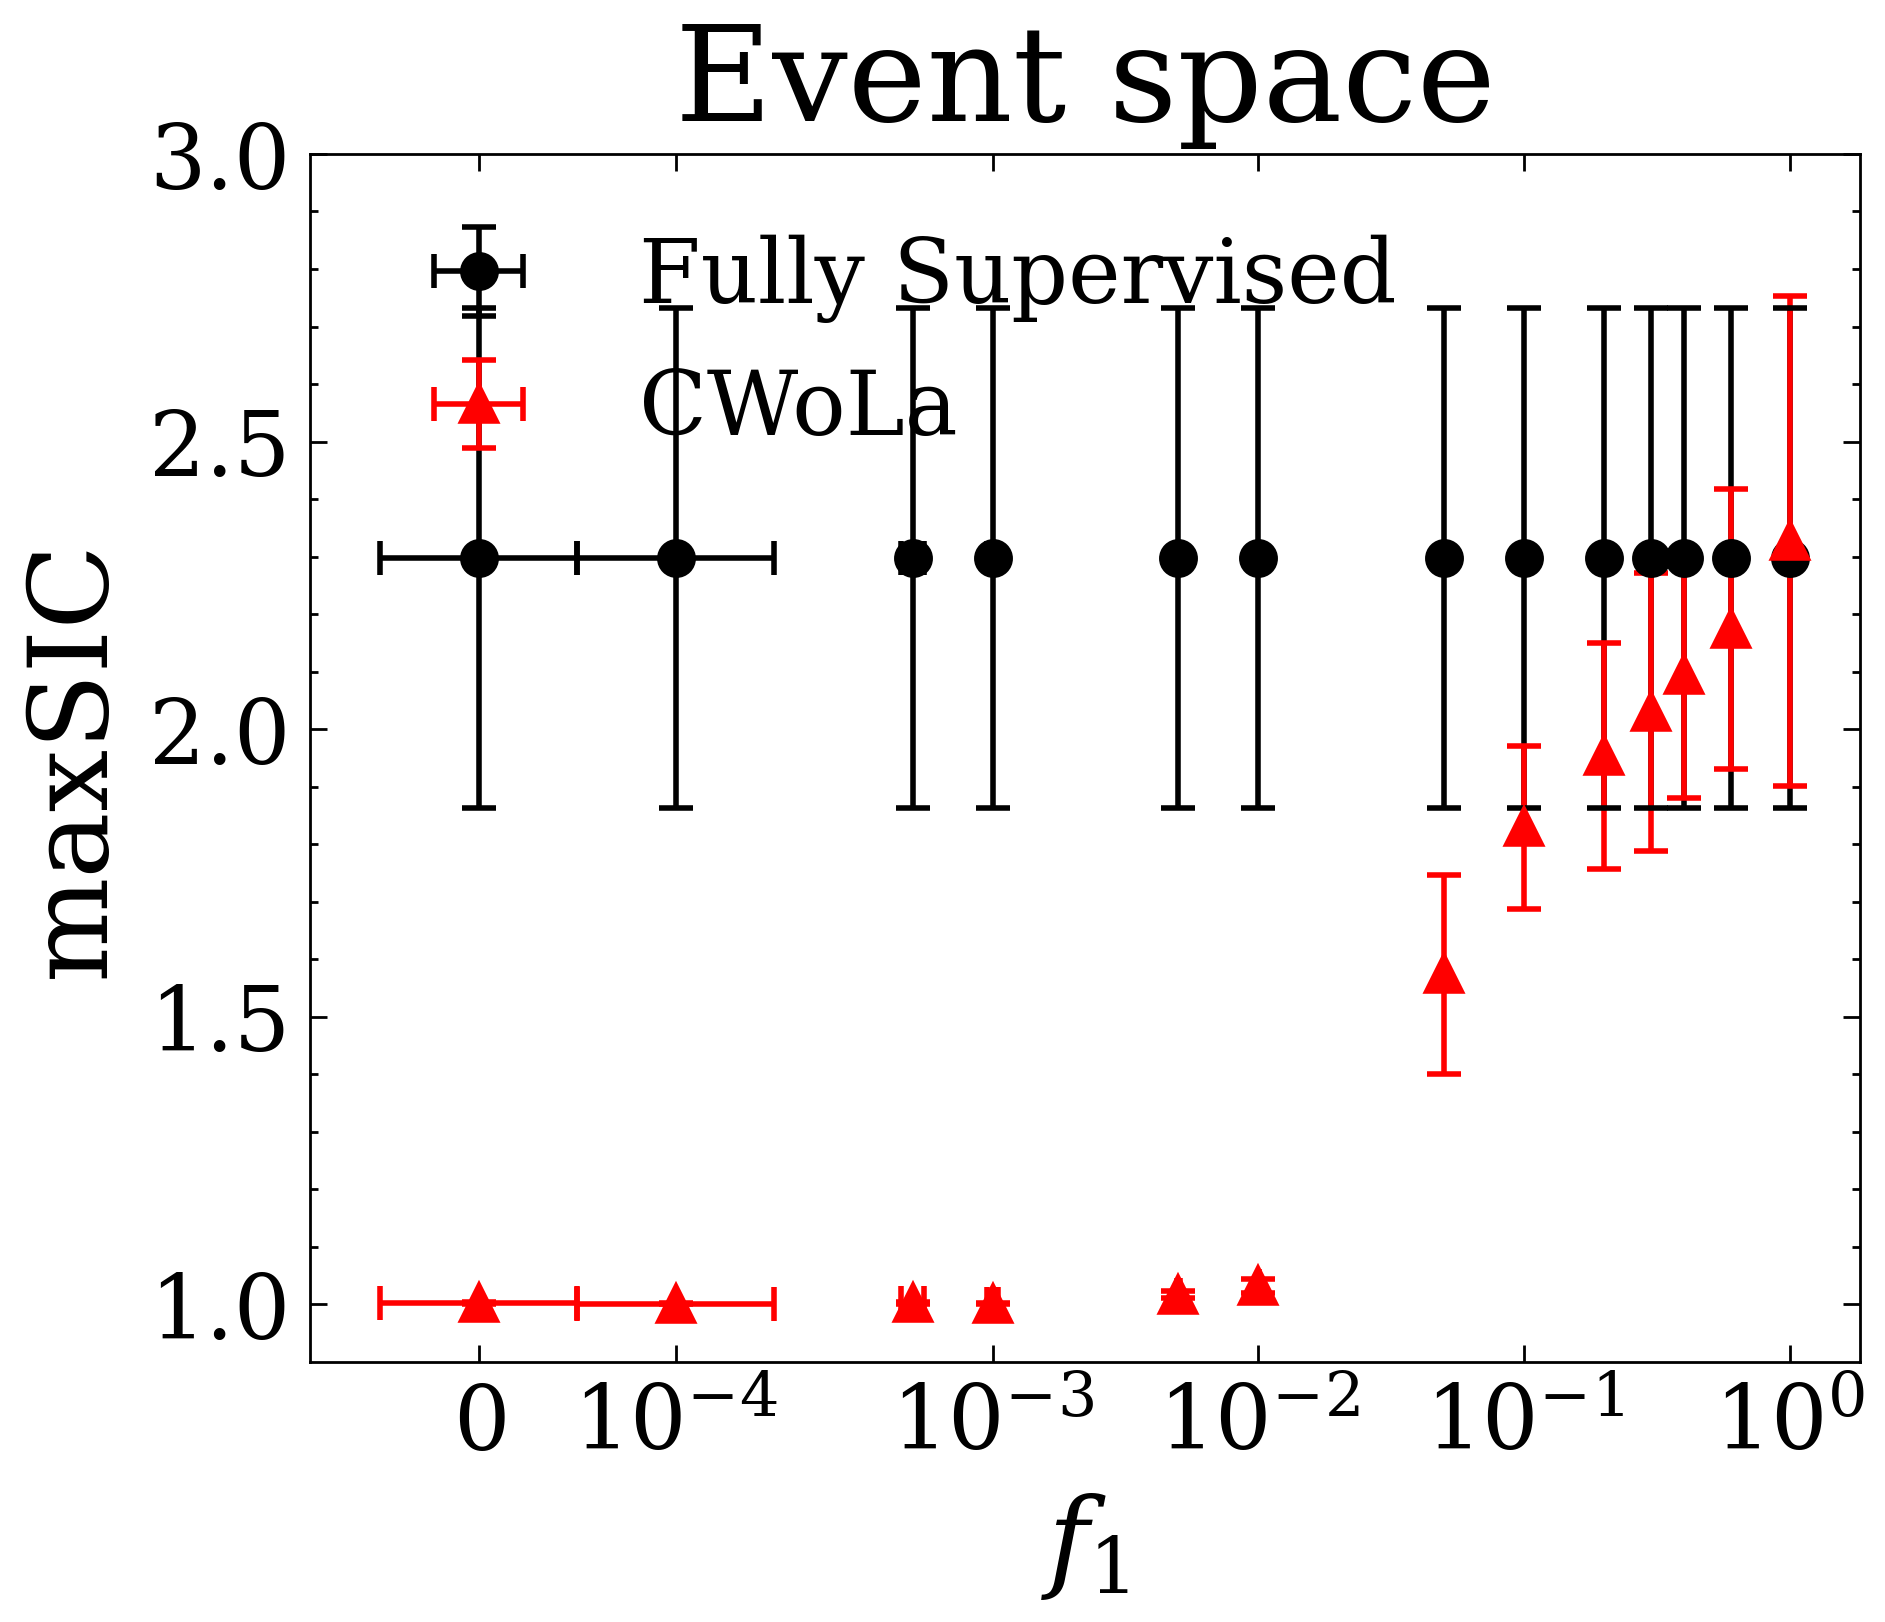

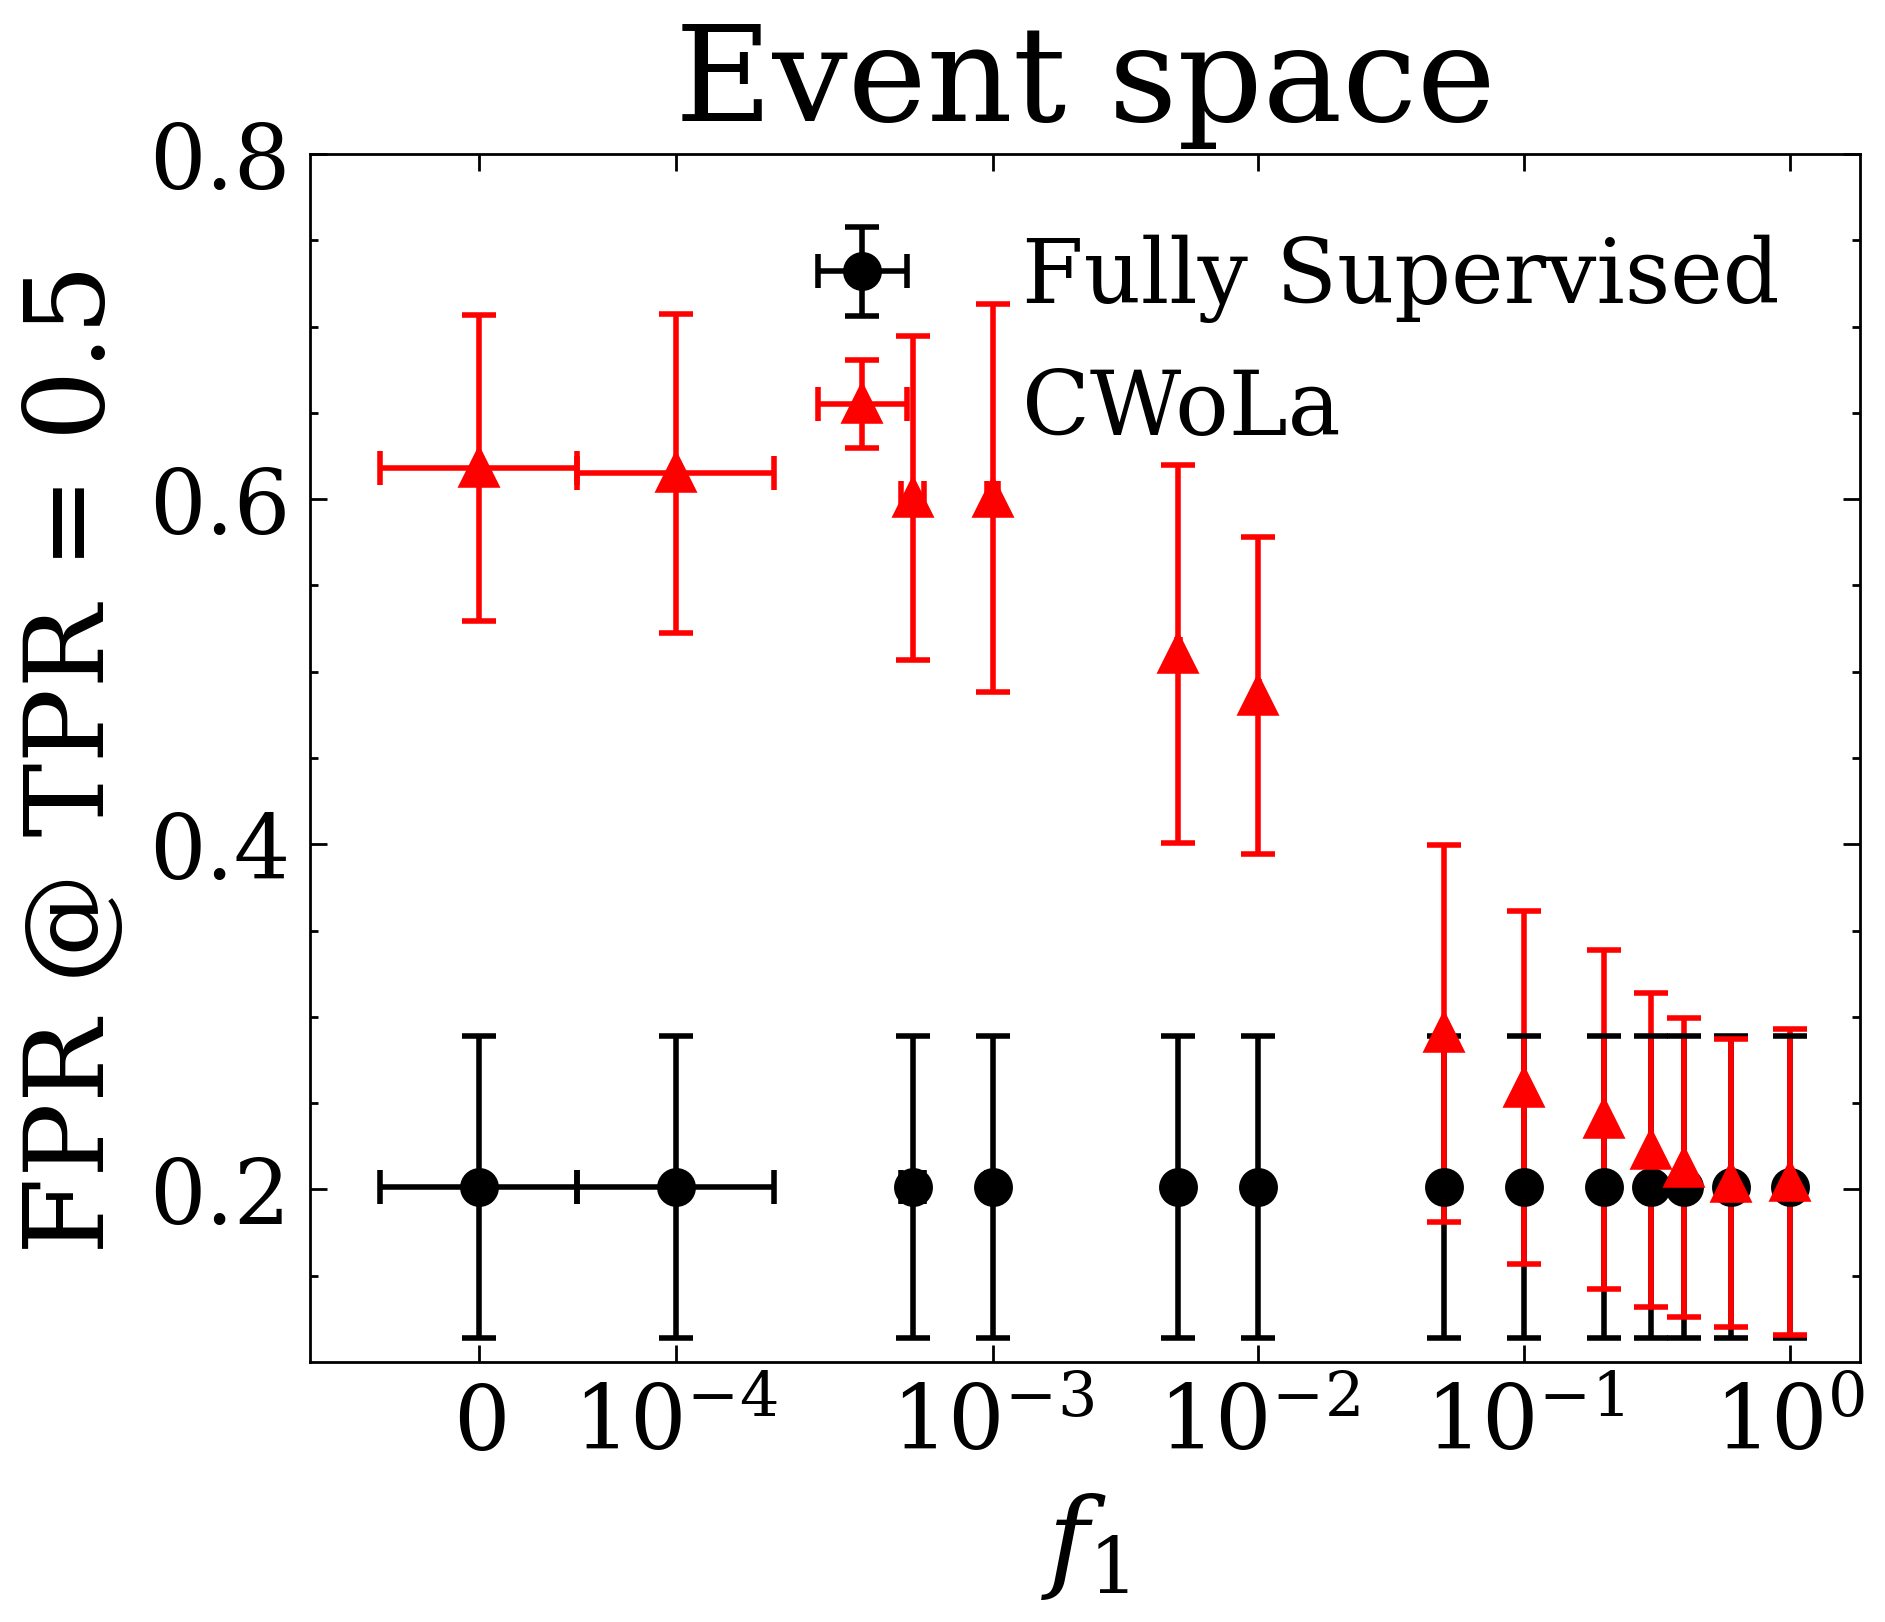

In [38]:
plt.style.use("science.mplstyle")

pdf_name = "JetCLR_CWoLa_ConstRep.pdf"
pp = PdfPages(pdf_name)

capsize = 3
xerr = .5*(f1_vals[1] - f1_vals[0])
linthresh = 0.00015



fig = plt.figure(figsize = (5,4))
plt.errorbar(f1_vals, avg_full_sup_results_dict["AUC"][0], yerr = avg_full_sup_results_dict["AUC"][1], label = "Fully Supervised", color = "k", capsize = capsize, fmt = "o", xerr = xerr)
plt.errorbar(f1_vals, avg_cwola_results_dict["AUC"][0], yerr = avg_cwola_results_dict["AUC"][1], label = "CWoLa", color = "r", capsize = capsize, fmt = "^", xerr = xerr)
plt.legend()
plt.xlabel("$f_1$")
plt.xscale("symlog", linthresh=linthresh)

plt.ylabel("AUC")
plt.ylim(0.45, 1)
plt.title("Event space")
plt.show()
pp.savefig(fig)


fig = plt.figure(figsize = (5,4))
plt.errorbar(f1_vals, avg_full_sup_results_dict["maxsic"][0], yerr = avg_full_sup_results_dict["maxsic"][1], label = "Fully Supervised", color = "k", capsize = capsize, fmt = "o", xerr = xerr)
plt.errorbar(f1_vals, avg_cwola_results_dict["maxsic"][0], yerr = avg_cwola_results_dict["maxsic"][1], label = "CWoLa", color = "r", capsize = capsize, fmt = "^", xerr = xerr)
plt.legend()
plt.xlabel("$f_1$")
plt.xscale("symlog", linthresh=linthresh)
plt.ylabel("maxSIC")
plt.ylim(0.9, 3)
plt.title("Event space")
plt.show()
pp.savefig(fig)

fig = plt.figure(figsize = (5,4))
plt.errorbar(f1_vals, avg_full_sup_results_dict["FPRatTPR"][0], yerr = avg_full_sup_results_dict["FPRatTPR"][1], label = "Fully Supervised", color = "k", capsize = capsize, fmt = "o", xerr = xerr)
plt.errorbar(f1_vals, avg_cwola_results_dict["FPRatTPR"][0], yerr = avg_cwola_results_dict["FPRatTPR"][1], label = "CWoLa", color = "r", capsize = capsize, fmt = "^", xerr = xerr)
plt.legend()
plt.xlabel("$f_1$")
plt.xscale("symlog", linthresh=linthresh)
plt.ylabel("FPR @ TPR = 0.5")
plt.ylim(0.1, 0.8)
plt.title("Event space")
plt.show()
pp.savefig(fig)


    
pp.savefig(fig)
pp.close()


